# Music Self-Supervised Learning Tutorial

## Contrastive Learning for Music Representation Learning

Welcome to this comprehensive tutorial on self-supervised learning for music! In this notebook, we'll explore how to build and train a contrastive learning model for learning meaningful representations from music audio data.

### What You'll Learn

By the end of this tutorial, you will understand:

1. **Data Preprocessing**: How to load and preprocess music audio data
2. **Augmentation Strategies**: Creating multiple views of the same audio for contrastive learning
3. **Model Architecture**: Building a VGGish backbone with projection head
4. **Contrastive Learning**: Implementing NTXent loss for representation learning
5. **Training Pipeline**: Setting up PyTorch Lightning for scalable training
6. **Visualization**: Monitoring training progress and embedding quality

### Prerequisites

- Basic knowledge of PyTorch and deep learning
- Familiarity with audio processing concepts
- Understanding of self-supervised learning principles

### Dataset

We'll be using the **Giantsteps** dataset, which contains electronic dance music tracks. This dataset is particularly suitable for contrastive learning as it contains diverse musical content that can benefit from learned representations.

---

## Table of Contents

1. [Setup and Imports](#setup)
2. [Data Loading and Exploration](#data-loading)
3. [Data Preprocessing and Augmentation](#preprocessing)
4. [Model Architecture](#model-architecture)
5. [Training Setup](#training-setup)
6. [Training Execution](#training-execution)
7. [Results and Visualization](#results)
8. [Next Steps](#next-steps)


## 1. Setup and Imports {#setup}

Let's start by importing the necessary libraries and setting up our environment. We'll be using PyTorch for deep learning, PyTorch Lightning for training, and various audio processing libraries.


In [1]:
# Import necessary libraries
import torch
import torchaudio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
from src.data.dataset import Giantsteps
from src.data.dataset import MultiView, MelSpectrogram, TimeFrequencyMask, Truncate
from src.models.backbones import VGGish, MLP
from src.models.training_wrappers import ContrastiveLearning
from src.utils.losses import NTXent
from src.data.collate import multiview_collate
from src.utils.viz import show_audio_and_spectrogram
from src.callbacks.viz2d import Embedding2DVisualizationCallback

# PyTorch Lightning imports
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {L.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")

✅ All imports successful!
PyTorch version: 2.6.0+cu124
PyTorch Lightning version: 2.4.0
CUDA available: True
CUDA device: NVIDIA RTX A5000


## 2. Data Loading and Exploration {#data-loading}

Now let's load our dataset and explore the music data. We'll start with a simple dataset load to understand the structure and listen to some samples.


In [2]:
# Load the Giantsteps dataset
print("Loading Giantsteps dataset...")
gs = Giantsteps()
print(f"Dataset loaded! Total samples: {len(gs)}")

# Get a sample from the dataset
sample = gs[0]
print(f"Sample keys: {sample.keys()}")
print(f"Audio shape: {sample['audio'].shape}")
print(f"Audio duration: {sample['audio'].shape[0] / 16000:.2f} seconds")

# Listen to the original audio
print("\n🎵 Original Audio Sample:")
Audio(sample['audio'], rate=16000)

Loading Giantsteps dataset...
Dataset loaded! Total samples: 600
Sample keys: dict_keys(['audio', 'view_1', 'view_2'])
Audio shape: torch.Size([48000])
Audio duration: 3.00 seconds

🎵 Original Audio Sample:


### Understanding the Data Structure

The dataset returns a dictionary with audio data. Let's examine the properties of our audio sample and understand what we're working with.


Audio tensor shape: torch.Size([48000])
Audio tensor dtype: torch.float32
Audio range: [-1.112, 1.092]
Audio mean: -0.001, std: 0.384


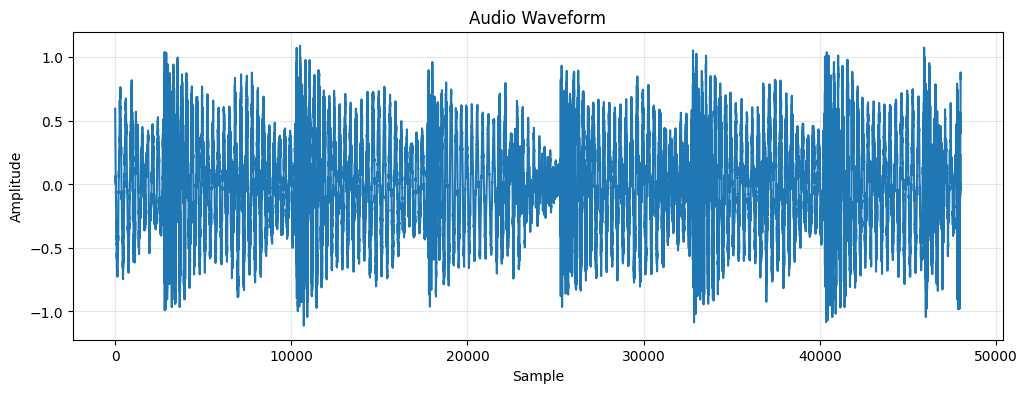

In [3]:

# Examine the audio properties
audio = sample['audio']
print(f"Audio tensor shape: {audio.shape}")
print(f"Audio tensor dtype: {audio.dtype}")
print(f"Audio range: [{audio.min():.3f}, {audio.max():.3f}]")
print(f"Audio mean: {audio.mean():.3f}, std: {audio.std():.3f}")

# Visualize the waveform
plt.figure(figsize=(12, 4))
plt.plot(audio.numpy())
plt.title("Audio Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.show()

# Note: The original dataset doesn't have views yet - we'll create them in the next section

## 3. Data Preprocessing and Augmentation {#preprocessing}

For contrastive learning, we need to create multiple views of the same audio sample. This is crucial because contrastive learning works by learning representations that are similar for different views of the same data and different for views of different data.

### Key Concepts in Contrastive Learning Data Augmentation

1. **Multi-View Generation**: Create different "views" of the same audio
2. **Mel Spectrogram Conversion**: Convert audio to frequency domain representation
3. **Data Augmentation**: Apply transformations to increase diversity

Let's set up our data processing pipeline:


In [4]:
# Define our data processing pipeline
processors = [
    # 1. MultiView: Create two random views of the same audio
    MultiView(view_samples=47999, strategy="random_view", keys=["audio"]),
    
]

# Create augmented dataset with our processors
print("\nCreating augmented dataset...")
gs_aug = Giantsteps(processors=processors, labels_=False)
print(f"Augmented dataset created! Total samples: {len(gs_aug)}")

# Get a sample from the augmented dataset
sample_aug = gs_aug[0]
print(f"Augmented sample keys: {sample_aug.keys()}")
print(f"View 1 shape: {sample_aug['view_1'].shape}")
print(f"View 2 shape: {sample_aug['view_2'].shape}")


Creating augmented dataset...
Augmented dataset created! Total samples: 600
Augmented sample keys: dict_keys(['audio', 'view_1', 'view_2'])
View 1 shape: torch.Size([47999])
View 2 shape: torch.Size([47999])


### Visualizing the Augmented Data

Now let's visualize our two views to understand how the augmentation works. We'll create mel spectrograms and display them side by side.


Creating mel spectrogram visualizations...


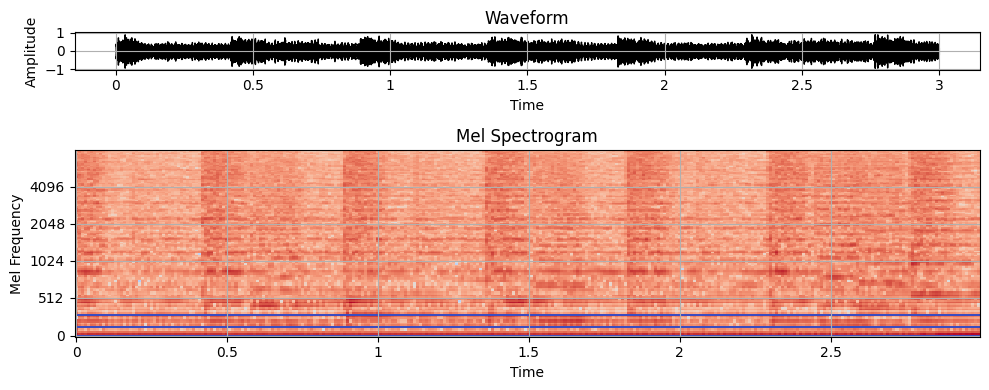

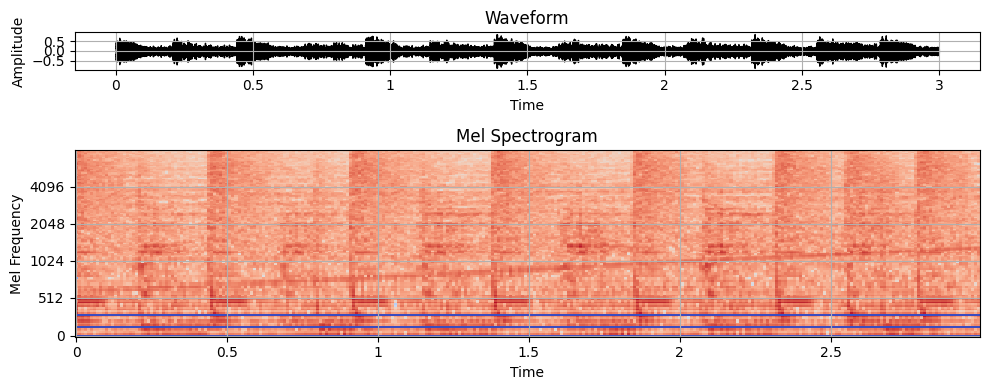

In [5]:
# Visualize the two views using our custom visualization function
print("Creating mel spectrogram visualizations...")
view1_fig = show_audio_and_spectrogram(sample_aug['view_1'], 16000, f_min=50, f_max=8000)
view2_fig = show_audio_and_spectrogram(sample_aug['view_2'], 16000, f_min=50, f_max=8000)


### Creating Data Loaders

Now let's create data loaders for training. We'll use a custom collate function that handles the multiview data structure properly.


In [6]:
# Create data loader with custom collate function

dataset = Giantsteps(
    processors = [
    MultiView(view_samples=47999, strategy="same_view", keys=["audio"]),
    
    MelSpectrogram(
        sample_rate=16000, 
        n_fft=512, 
        hop_length=160, 
        n_mels=128, 
        f_min=50, 
        f_max=8000, 
        win_length=None, 
        power=2.0, 
        keys=["view_1", "view_2", 'audio']
    ),
    TimeFrequencyMask(keys=["view_1", "view_2", 'audio'])
    ],
    labels_=False
)

batch_size = 64
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=multiview_collate,
    num_workers=4
)


# Test the data loader with a single batch
batch = next(iter(dataloader))
print(f"Batch keys: {batch.keys()}")
print(f"Views shape: {batch['views'].shape}")
print(f"Expected shape: [batch_size * 2, channels, height, width] = [64, 128, 300]")

view_1 = batch['views'][0]
view_2 = batch['views'][16]

print(view_1.shape)
print(view_2.shape)

fig,ax = plt.subplots(1,2,figsize=(10,5))
librosa.display.specshow(view_1.numpy(), ax=ax[0], sr=16000, x_axis='time', y_axis='mel', fmax=8000, fmin=50)
librosa.display.specshow(view_2.numpy(), ax=ax[1], sr=16000, x_axis='time', y_axis='mel', fmax=8000, fmin=50)



[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/homes/jpmg86/anaconda3/envs/nclap/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/homes/jpmg86/anaconda3/envs/nclap/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/homes/jpmg86/Music-SSL-ISMIR/src/data/collate.py", line 41, in multiview_collate
    remaining_batch = default_collate(remaining_items)
  File "/homes/jpmg86/anaconda3/envs/nclap/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/homes/jpmg86/anaconda3/envs/nclap/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 171, in collate
    {
  File "/homes/jpmg86/anaconda3/envs/nclap/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 172, in <dictcomp>
    key: collate(
  File "/homes/jpmg86/anaconda3/envs/nclap/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/homes/jpmg86/anaconda3/envs/nclap/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [0, 12009] at entry 0 and [0, 11986] at entry 7


[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1841] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1841] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1841] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1841] err

## 4. Model Architecture

Now let's build our contrastive learning model. We'll use a two-part architecture:

1. **Backbone**: VGGish-style CNN for feature extraction
2. **Projection Head**: MLP for contrastive learning

### Understanding the Architecture

The VGGish backbone processes mel spectrograms and extracts high-level features, while the projection head maps these features to a lower-dimensional space suitable for contrastive learning.


In [ ]:
# Create the VGGish backbone
print("Creating VGGish backbone...")
vggish = VGGish(
    proj_dim=512,
    channels=[128, 256, 512, 1024]
)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f"VGGish parameters: {count_parameters(vggish):,}")

# Test with real batch
print("\nTesting backbone with real batch...")
with torch.no_grad():
    real_output = vggish(batch['views'])
    print(f"Real batch output shape: {real_output['z'].shape}")


Creating VGGish backbone...
VGGish parameters: 19,954,560

Testing backbone with real batch...
Real batch output shape: torch.Size([128, 512])


### Creating the Projection Head

The projection head is crucial for contrastive learning. It maps the high-dimensional backbone features to a lower-dimensional space where we can compute similarities effectively.


In [ ]:
# Create the projection head
print("Creating MLP projection head...")
projection_head = MLP(
    in_features=512,      # Input from VGGish backbone
    out_features=128,     # Output dimension for contrastive learning
    hidden_features=[512, 512],  # Hidden layers
    activation="relu",
    use_batch_norm=True,
    dropout=0.0,
    bias=True
)

print(f"Projection head parameters: {count_parameters(projection_head):,}")

# Test the projection head
print("\nTesting projection head...")
with torch.no_grad():
    # Use the backbone output from our real batch
    backbone_features = vggish(batch['views'])['z']
    projected_features = projection_head(backbone_features)
    
    print(f"Backbone features shape: {backbone_features.shape}")
    print(f"Projected features shape: {projected_features.shape}")
    print(f"Expected: [batch_size * 2, projection_dim] = [64, 128]")

print(f"\nTotal model parameters: {count_parameters(vggish) + count_parameters(projection_head):,}")

Creating MLP projection head...
Projection head parameters: 593,024

Testing projection head...
Backbone features shape: torch.Size([128, 512])
Projected features shape: torch.Size([128, 128])
Expected: [batch_size * 2, projection_dim] = [64, 128]

Total model parameters: 20,547,584


## 5. Training Setup {#training-setup}

Now let's set up the contrastive learning training pipeline. We'll use:

1. **NTXent Loss**: Normalized Temperature-scaled Cross Entropy loss
2. **Adam Optimizer**: For parameter updates
3. **PyTorch Lightning**: For scalable training

### Understanding Contrastive Learning

Contrastive learning works by:
- **Positive pairs**: Different views of the same sample should have similar representations
- **Negative pairs**: Different samples should have different representations
- **Loss function**: Minimizes distance between positive pairs, maximizes distance between negative pairs


In [ ]:
# Configure loss function
loss_params = {
    "_name_": "src.utils.losses.NTXent",
    "_kwargs_": {
        "temperature": 0.07,
        "contrast_mode": "all",
        "base_temperature": 0.07
    }
}

# Configure optimizer
opt_params = {
    "_name_": "torch.optim.Adam",
    "_kwargs_": {"lr": 0.0001}
}



# Create the ContrastiveLearning model
print("\nCreating ContrastiveLearning model...")
CL = ContrastiveLearning(
    backbone=vggish,
    projection_head=projection_head,
    loss_params=loss_params,
    opt_params=opt_params,
    sched_params=None,
    ema_params=None
)

print("✅ ContrastiveLearning model created successfully!")
# Test a single training step
print("\nTesting training step...")
test_loss = CL.training_step(batch, 0)
print(f"Training step completed! Loss: {test_loss:.4f}")



Creating ContrastiveLearning model...
✅ ContrastiveLearning model created successfully!

Testing training step...
Training step completed! Loss: 5.0606


## 6. Training Execution

Now let's set up and run the training! We'll use PyTorch Lightning for scalable training with:

- **Weights & Biases**: For experiment tracking and visualization
- **Rich Model Summary**: For detailed model architecture overview
- **Embedding Visualization**: For monitoring learned representations



In [ ]:
# Set up Weights & Biases logger
print("Setting up Weights & Biases logger...")
wandb_logger = WandbLogger(
    project="music-ssl-ismir",
    log_model=True
)



# Set up callbacks
print("Setting up training callbacks...")
callbacks = [
    # Rich model summary for detailed architecture overview
    L.pytorch.callbacks.RichModelSummary(max_depth=2),
    
    # Embedding visualization for monitoring learned representations
    Embedding2DVisualizationCallback(
        every_n_steps=100,
        reduction_method="umap",
    )
]

# Create the trainer
print("Creating PyTorch Lightning trainer...")
trainer = L.Trainer(
    max_epochs=100,
    devices=[6],
    accelerator='gpu',
    precision='16-mixed',
    logger=wandb_logger,
    callbacks=callbacks,
    log_every_n_steps=100,
    val_check_interval=1.0,
    gradient_clip_val=1.0,
    deterministic=True
)



Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Setting up Weights & Biases logger...
Setting up training callbacks...
Creating PyTorch Lightning trainer...


In [ ]:
trainer.fit(CL, train_dataloaders=dataloader, val_dataloaders=dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━┓
┃    ┃ Name                        ┃ Type              ┃ Params ┃ Mode ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━┩
│ 0  │ backbone                    │ VGGish            │ 20.0 M │ eval │
│ 1  │ backbone.blocks             │ ModuleList        │ 18.7 M │ eval │
│ 2  │ backbone.res_convs          │ ModuleList        │  690 K │ eval │
│ 3  │ backbone.maxpools           │ ModuleList        │      0 │ eval │
│ 4  │ backbone.avgpool            │ AdaptiveAvgPool2d │      0 │ eval │
│ 5  │ backbone.fc                 │ Linear            │  524 K │ eval │
│ 6  │ loss                        │ NTXent            │      0 │ eval │
│ 7  │ loss.sim_function           │ CosineSimilarity  │      0 │ eval │
│ 8  │ projection_head             │ MLP               │  593 K │ eval │
│ 9  │ projection_head.layers      │ ModuleList        │  590 K │ eval │
│ 10 │ projection_head.batch_norms │ ModuleList        │  2.0 K │ eval │
│ 11 │ model                       │ ModuleDict        │ 20.5 M │ eval │
└────┴─────────────────────────────┴───────────────────┴────────┴──────┘

Trainable params: 20.5 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 20.5 M                                                                                               
Total estimated model params size (MB): 82                                                                         
Modules in train mode: 0                                                                                           
Modules in eval mode: 49

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1841] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

[src/libmpg123/layer3.c:INT123_do_layer3():1841] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1841] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] err

Epoch 8: 100%|██████████| 10/10 [02:08<00:00,  0.08it/s, v_num=ez7b, loss_step=-3.26, loss_epoch=-2.12]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 48000]

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

Extracting embeddings from test samples...


[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


Similarity matrix shape: torch.Size([32, 32])
Positive pair similarities (first 10): [0.9598395228385925, 0.9861694574356079, 0.9348125457763672, 0.9178276062011719, 0.9048898816108704, 0.9171997308731079, 0.59512859582901, 0.9702869653701782, 0.8894302845001221, 0.9707106351852417]
Average positive similarity: 0.9174
Std positive similarity: 0.0895


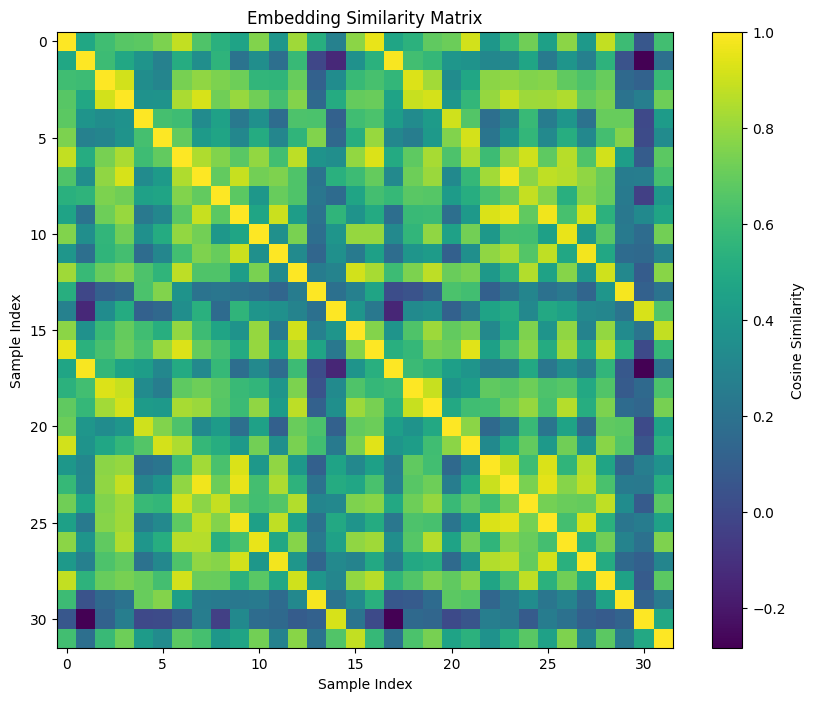

In [ ]:
import torch.nn.functional as F

# Set model to evaluation mode
CL.eval()

# Extract embeddings from a few samples
print("Extracting embeddings from test samples...")
with torch.no_grad():
    # Get a batch of data
    test_batch = next(iter(dataloader))
    
    # Extract features using the backbone
    backbone_features = CL.backbone(test_batch['views'])['z']
    
    # Project to embedding space
    embeddings = CL.projection_head(backbone_features)
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    # Compute similarity matrix
    similarity_matrix = torch.mm(embeddings, embeddings.t())
    print(f"Similarity matrix shape: {similarity_matrix.shape}")
    
    # Show similarity between positive pairs (should be high)
    batch_size = test_batch['views'].shape[0] // 2
    positive_similarities = []
    for i in range(batch_size):
        sim = similarity_matrix[i, i + batch_size].item()
        positive_similarities.append(sim)
    
    print(f"Positive pair similarities (first 10): {positive_similarities[:10]}")
    print(f"Average positive similarity: {np.mean(positive_similarities):.4f}")
    print(f"Std positive similarity: {np.std(positive_similarities):.4f}")

# Visualize the similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title('Embedding Similarity Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.show()
